# Unify Deterministic and Stochastic Gradient Descent

This is one way to unify Deterministic and Stochastic Gradient Descent. The idea is that the basic steps are the same, bu the stochastic GD is used to minimize a loss function which is a sum over data.


However, since SGD can be optimized for the problems it is designed to solve, one needs to do it separetely. 

In [1]:
import numpy as np


import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
class GradientDescent:
    '''This is inteded to be used as a base class for a class that describes the type of Gradient Descent'''
    
    
    
    def update(self,alpha=1e-2):
        '''alpha: the alpha parameter'''
        
        grad=self.Grad()
        self.position = [ self.position[i] - alpha*g for i,g in enumerate(grad)]

        return grad
        
        
    
    
    def run(self, alpha=1e-2,tol=1e-5, step_break=100):
        '''        
        alpha: the alpha parameter
        tol, step_break: stop when the gradient becomes smaller than tol/alpha for step_break consecutive steps
        '''
        _s=0
        
        self.steps=[]#store the steps here
        
        while True:
            grad=self.update(alpha)
            
            _check= np.sqrt(np.sum([_**2 for _ in grad] ))
            
            self.steps.append(self.position)
            
            if _check<tol/alpha:
                _s+=1
            else:
                _s=0
            
            if _s>step_break:
                break
        
        
        return self.position

# Deterministic Gradient Descent

In [3]:
class DeterministicGD(GradientDescent):
    '''
    Deterministic Gradient Descent
    It inherits update and run from GradientDescent.
    '''
    def __init__(self,target,initial_position):
        '''
        target: the function to be minimized
        initial_position some initial position to start the GD algorithm
        '''
        self.target =target 
        self.position=initial_position
        
        #store the dimention of the input of target
        self.dim=len(self.position)
    
    def __call__(self):
        '''Define __call__ so that self() returns the value of self.target at self.position'''
        return self.target(self.position)
    
    
    def Grad(self,h=1e-5):
        '''
        Define the Gradient of self.target. As with __call__, Grad is evaluated at self.position.
        
        h: the h parameter used to calculate the derivatives. 
        '''
        
        grad=[]
        for dim in range(self.dim):
            
            self.position[dim] -= h
            dfdx0=self() 
            
            self.position[dim] += 2*h
            dfdx1=self()  
            
            grad.append((dfdx1-dfdx0)/(2*h))
               
            self.position[dim]-=h
        
        
        return grad
            
        

# Example

Let's minimize $$ f(x_1,x_2) = 1- e^{ -( x_1^2 + x_2^2)  }  $$

In [4]:
DGD=DeterministicGD(lambda x: 1-np.exp(-(x[0]**2+x[1]**2)),[.2,.3])

In [5]:
DGD.run(alpha=1e-2,tol=1e-5, step_break=100)

[3.544197321119725e-05, 5.3162959622411824e-05]

<IPython.core.display.Javascript object>


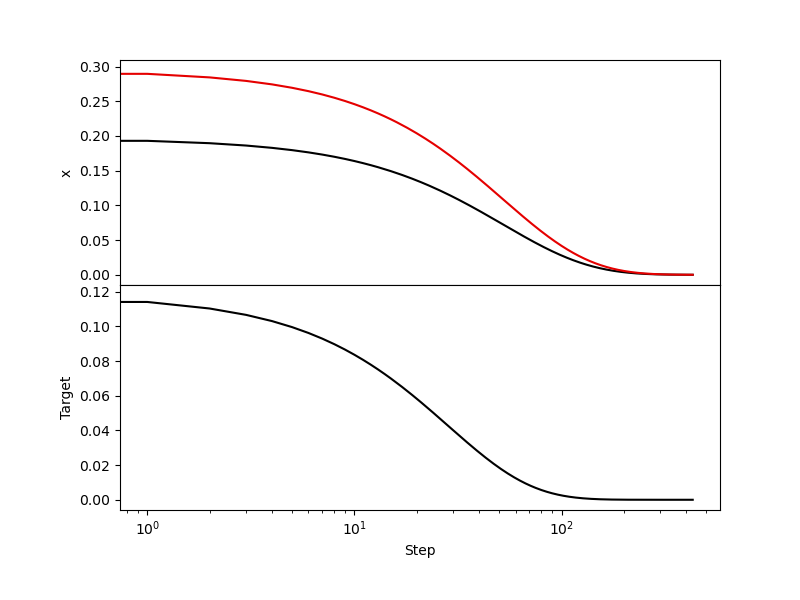

In [6]:
fig=plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.get_xaxis().set_visible(False)
sub.plot(np.array(DGD.steps)[:,0],c='xkcd:black')
sub.plot(np.array(DGD.steps)[:,1],c='xkcd:red')

sub.set_ylabel('x')
sub.set_xscale('log')
sub.set_yscale('linear')


sub = fig.add_subplot(212)
sub.plot([DGD.target(i) for i in DGD.steps],c='xkcd:black')

sub.set_ylabel('Target')

sub.set_xscale('log')
sub.set_yscale('linear')

sub.set_xlabel('Step')

plt.show()

# Stochastic Gradient Descent

In [7]:
class targetFunc:
    '''
    This is how the function should look like.
    The key point is to have way to update the parameters w.
    '''
    def __init__(self,func,w0):
        self.f=func
        self.w=w0
        self.dim=len(w0)
    
    
    
    def __call__(self,x):
        return self.f(self,x)

In [8]:
class StochasticGD(GradientDescent):
    '''
    StochasticGD inherits update and run from GradientDescent.
    This class is ment to be used in order to minimize the loss of a function given some data.
    '''
    def __init__(self,loss,target,data):
        '''
        loss: the loss function
        target: the target function, instance of targetFunc
        data: the data used in order to minimize loss(target, list of inputs, list of outputs)
        
        The signature of target function is (self,x) and the adjustable parameters are called by self.w
        The data are of the form [ [[x1[0],x1[1],...],[t1[0],t[1],...]], [[x2[0],x2[1],...],[t3[0],t[1],...]], ...],
        with x1,x2... are the inputs that result to  t1,t2,... 
        
        
        #for example consider 
        the target function f(x)=w_1*x+w_2 and
        the loss function Q_i=(f(x_i) -t_i)^2,
        with the data being values of x_i that result to t_i
        
        the implementation is 
        
        f = targetFunc( lambda self,x:[x[0]*self.w[0] +self.w[1]]), w are adjustable parameters 
        
        loss =  lambda g,x,t: np.mean([(g(x)[i] - _t)**2 for i,_t in enumerate(t)]), where the mean averaged
        the loss over the dimention of the output.
        
        
        Then, we can find the parameters  self.w, given some data, so that the loss is minimized as:
        
        SGD=StochasticGD(loss,f,data)
        
        SGD.run()
        
        
        '''
        self.lossFunc=loss
        self.targetFunc=target
        self.data=data

        self.data_size=len(self.data)
        self.position=self.targetFunc.w
        self.dim=len(self.position)
         
    def __call__(self,i):
        '''
        Change call so that you calculate the loss of the i-th data-point with the self.targetFunc.w
        set to self.position
        '''
        
        x=self.data[i][0]
        t=self.data[i][1]
        
        # change self.targetFunc.w to self.position, so that self.targetFunc is evaluated there.
        self.targetFunc.w=self.position   
        return self.lossFunc(self.targetFunc,x,t)
    
    def Grad(self,h=1e-5):
        grad=[]
        index=np.random.randint(self.data_size)
        for dim in range(self.dim):
            
            self.position[dim]-=h
            dQdw0=self(index)

            self.position[dim]+=2*h
            dQdw1=self(index) 
            
            self.position[dim]-=h

            grad.append((dQdw1-dQdw0)/(2*h))
            
            
        
        return grad
            
        

# Example 

Let's try to find $f(x)$ so that $f(x)=1/f(x)$ $x \in [-1,1]$. To do this we define $Q[f_{\bf w}]=\Big(f_{\bf w}(x)-1/f_{\bf w}(x) \Big)^2$.

To do this, we define $f_{\bf w} \equiv w_0 x + w_1$. Since the answer is $f(x)= \pm 1$, we expect $w_0=0$ and $w_1 = \pm 1$.

In [9]:
def testFunc(self,x):
    return [x[0]*self.w[0]+ self.w[1]]

def loss(f,x,t):
    return np.mean([(f(x)[i] - _t)**2 for i,_t in enumerate(t)])

In [40]:
f=targetFunc(testFunc,[-5,20])

data=[]
xmin=-5
xmax=2
for i in range(500):
    x=np.random.rand()*(xmax-xmin)+xmin
    data.append( [[x],[2*x+3]])

SGD=StochasticGD(loss , f,data)


In [41]:
SGD.run(alpha=5e-2,tol=1e-5, step_break=50)

[2.0000002794983, 3.00000103618904]

In [42]:
fig=plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.get_xaxis().set_visible(False)
sub.plot(np.array(SGD.steps)[:,0],c='xkcd:black')
sub.plot(np.array(SGD.steps)[:,1],c='xkcd:red')

sub.set_ylabel('x')
# sub.set_xscale('log')
sub.set_yscale('linear')


sub = fig.add_subplot(212)
meanQ=[]
for w in SGD.steps:
    f.w=w
    _=np.mean( [loss(f, data[i][0], data[i][1]  ) for i in range(SGD.data_size)] )
    meanQ.append(_)
sub.plot(meanQ,c='xkcd:black')

sub.set_ylabel('Mean of $Q$')

# sub.set_xscale('log')
sub.set_yscale('log')

sub.set_xlabel('Step')

plt.show()

<IPython.core.display.Javascript object>